# Decision Tree Lab

In [ ]:
import numpy as np
import pandas as pd
import pprint
eps = np.finfo(float).eps
from numpy import log2 as log
from scipy.io.arff import loadarff

# 1 Correctly implement the ID3 decision tree algorithm, including the ability to handle unknown attributes

In [ ]:
class DTClassifier():

    def __init__(self):
        self.information_gain_list = []
        self.full_tree = {}


    def buildTree(self, df, tree=None): 
        target = df.keys()[-1]   # get unique values of labels

        # Get attribute with max info gain
        node = self.best_info_gain(df)
        
        # Get distinct values of the node
        distinctVal = np.unique(df[node])
        
        # empty dictionary to create tree    
        if tree is None:                    
            tree={}
            tree[node] = {}
         
        # loop to build tree
        for value in distinctVal:
            
            subtable = self.temp_table(df,node,value)
            clValue,counts = np.unique(subtable[target],return_counts=True)                        
            
            if len(counts)==1: 
                tree[node][value] = clValue[0]                                                    
            else:        
                tree[node][value] = self.buildTree(subtable) # do recursion

            # storing tree in global variable
            self.full_tree = tree

        return tree

        
    def calc_entropy(self, df):
        labels = df.keys()[-1]   
        entropy = 0
        values = df[labels].unique()
        for value in values:
            pi = df[labels].value_counts()[value]/len(df[labels])
            entropy += -pi*np.log2(pi)
        return entropy
    
    
    def calc_entropy_attributes(self, df, attribute):
        target = df.keys()[-1]   
        unique_labels = df[target].unique()  #get unique labels
        variables = df[attribute].unique()    #get unique values of attribute
        entropy2 = 0
        for v in variables:
            entropy = 0
            for label in unique_labels:
                num = len(df[attribute][df[attribute]==v][df[target] ==label])
                den = len(df[attribute][df[attribute]==v])
                pi = num/(den+eps)
                entropy += -pi*log(pi+eps)
            fraction = den/len(df)
            entropy2 += -fraction*entropy
        return abs(entropy2)


    def best_info_gain(self, df):
        info_gain = []
        for key in df.keys()[:-1]:
            info_gain.append(self.calc_entropy(df)-self.calc_entropy_attributes(df,key))
        
        self.information_gain_list.append(max(info_gain))

        return df.keys()[:-1][np.argmax(info_gain)]
    
    
    def temp_table(self, df, node,value):
        return df[df[node] == value].reset_index(drop=True)



    def predict(self, data):
        queries = data.iloc[:,:-1].to_dict(orient="records")
        predicted = pd.DataFrame(columns=["predicted"])

        #calculation of accuracy
        for i in range(len(data)):
            predicted.loc[i,"predicted"] = self.predict_tree_algo(queries[i], self.full_tree, 1.0)

        return (np.sum(predicted["predicted"]==data[data.keys()[-1]])/len(data))


    def predict_tree_algo(self, query, tree, default=1):
        for x in list(query.keys()):
            if x in list(tree.keys()):
                try:
                    result = tree[x][query[x]]
                except:
                    return default

                result = tree[x][query[x]]
                if isinstance(result,dict):
                    return self.predict_tree_algo(query,result)
                else:
                    return result


    def get_info_gain(self):
        return self.information_gain_list

    
    def get_full_tree(self):
        return self.full_tree

My DTClassifier() class has several additional methods that were not included in the "recommended" code scaffolding. The buildTree() method is a recursive method that builds the tree nodes using the "tree" variable. Inside this method, I call the temp_subtable() and use the values in subtable to go through the algorithm

## 1.1 Debug

In [ ]:
## Load debug training data
import pandas as pd
from scipy.io.arff import loadarff

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/lenses.arff --output debug_data_train.arff

dataset = loadarff('debug_data_train.arff')
df_debug = pd.DataFrame(dataset[0])
str_df = df_debug.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    df_debug[col] = str_df[col]


## Train Decision Tree
clf_debug = DTClassifier()
debug_tree = clf_debug.buildTree(df_debug)


## Load debug test data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/lenses_test.arff --output debug_data_test.arff

dataset = loadarff('debug_data_test.arff')
df_debug_test = pd.DataFrame(dataset[0])
str_df = df_debug_test.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    df_debug_test[col] = str_df[col]
print()
print("-----------------------------------------")
print()
print()


## Predict and compute model accuracy
test_accuracy = clf_debug.predict(df_debug_test)
print(f'Test accuracy: \t {round(test_accuracy, 2)*100}%')
print()

## Print the information gain of every split you made
print(f'Information Gain of each split: {clf_debug.get_info_gain()}')
print()
print("Tree:")
pprint.pprint(debug_tree)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2890  100  2890    0     0  62826      0 --:--:-- --:--:-- --:--:-- 62826
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2839  100  2839    0     0  49807      0 --:--:-- --:--:-- --:--:-- 50696

-----------------------------------------


Test accuracy: 	 33.0%

Information Gain of each split: [0.5487949406953989, 0.7704260414863784, 0.31668908831502124, 1.0, 0.4591479170272453, 0.9182958340544896]

Tree:
{'tear_prod_rate': {'normal': {'astigmatism': {'no': {'age': {'pre_presbyopic': 'soft',
                                                              'presbyopic': {'spectacle_prescrip': {'hypermetrope': 'soft',
                                                                                                   

## 1.2 Evaluation

In [ ]:
## Loading eval training dataset
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/zoo.arff --output eval_data_train.arff
dataset = loadarff('eval_data_train.arff')
df_eval_train = pd.DataFrame(dataset[0])
str_df = df_eval_train.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()

for col in str_df:
    df_eval_train[col] = str_df[col]


## Train decision tree
clf_eval = DTClassifier()
eval_tree = clf_eval.buildTree(df_eval_train)


## Loading eval test dataset
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/zoo_test.arff --output eval_data_test.arff
dataset = loadarff('eval_data_test.arff')
df_eval_test = pd.DataFrame(dataset[0])
str_df = df_eval_test.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()

for col in str_df:
    df_eval_test[col] = str_df[col]


## Info gain and accuracy
test_accuracy_eval = clf_eval.predict(df_eval_test)
print("-------------------------------")
print()
print(f'Accuracy of evaluation test dataset: \t{test_accuracy_eval * 100}%')
print(f'Information Gain of each split: \t{clf_eval.get_info_gain()}')






  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6683  100  6683    0     0   116k      0 --:--:-- --:--:-- --:--:--  116k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  171k  100  171k    0     0  2448k      0 --:--:-- --:--:-- --:--:-- 2448k
-------------------------------

Accuracy of evaluation test dataset: 	14.7%
Information Gain of each split: 	[1.3630469031539403, 0.8865408928220906, 0.9852281360342512, 0.6962122601251456, 0.8256265261578951, 0.6892019851173661, 0.8631205685666313, 0.7219280948873621, 0.721928094887362]


# 2. Use your ID3 algorithm to induce decision trees for the cars dataset and the voting dataset.

## 2.1 Implement Cross Validation

In [ ]:
## Building cross validation function
def cross_validation(dataframe, cross):
  
  nFolds = cross
  lst = list(range(1,nFolds+1))
  dataframe['New'] = 0
  dataframe = dataframe.sample(frac=1).reset_index()

  # add a new column and number random rows
  for i, row in enumerate(dataframe.itertuples()):
    # dataframe['New'][i] = (i%nFolds + 1)
    dataframe.loc[i, 'New'] = (i%nFolds + 1)
  dataframe.drop(columns=['index'], inplace=True)

  # create arrays of new splits
  cv_splits = []
  for i in range(nFolds):
    trainIndices = dataframe[ dataframe['New']!=i+1 ].index.values.astype(int)
    testIndices =  dataframe[ dataframe['New']==i+1 ].index.values.astype(int)
    cv_splits.append( (trainIndices, testIndices) )
  
  test_accuracy_nfold = []
  train_accuracy_nfold = [] 
  list_final_trees = []

  for split in cv_splits:
    df_cv_train = dataframe.loc[split[0]]
    df_cv_train.drop(columns=['New'], inplace=True)
    df_cv_train.reset_index(drop=True, inplace=True)
    
    df_cv_test = dataframe.loc[split[1]]
    df_cv_test.drop(columns=['New'], inplace=True)
    df_cv_test.reset_index(drop=True, inplace=True)


    clf_splits = DTClassifier()
    model_tree = clf_splits.buildTree(df_cv_train)

    test_accuracy = clf_splits.predict(df_cv_test)
    train_accuracy = clf_splits.predict(df_cv_train)
    
    # append accuracy of this split to list and the tree
    test_accuracy_nfold.append(test_accuracy)
    train_accuracy_nfold.append(train_accuracy)
    list_final_trees.append(model_tree)
  
  return test_accuracy_nfold, train_accuracy_nfold, list_final_trees 



## 2.2 Cars Dataset

In [ ]:
# Load cars dataset
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/cars.arff --output cars.arff
dataset = loadarff('cars.arff')
df_cars = pd.DataFrame(dataset[0])
str_df = df_cars.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    df_cars[col] = str_df[col]


# Call cross_validation function
accuracy_test, accuracy_train, cars_tree = cross_validation(df_cars, 10)


# Report training and test classification accuracies in dataframe
df_score_cars = pd.DataFrame({'Test Accuracy': accuracy_test, 'Train Accuracy': accuracy_train}).round(5)
df_score_cars.index.name = 'Split'
df_score_cars.loc['Average'] = df_score_cars.mean()
df_score_cars['Test Accuracy'] = ((df_score_cars['Test Accuracy'])*100).round(2).astype(str) + '%'
df_score_cars['Train Accuracy'] = ((df_score_cars['Train Accuracy'])*100).round(2).astype(str) + '%'

print()
print("-----------------")
df_score_cars

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55386  100 55386    0     0   370k      0 --:--:-- --:--:-- --:--:--  370k

-----------------


,Test Accuracy,Train Accuracy
Split,,
0,89.6%,100.0%
1,87.86%,100.0%
2,87.86%,100.0%
3,86.7%,100.0%
4,90.17%,100.0%
5,93.64%,100.0%
6,91.33%,100.0%
7,91.33%,100.0%
8,84.3%,100.0%


## 2.3 Voting Dataset

In [ ]:
# Load voting dataset
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting_with_missing.arff --output voting.arff
dataset = loadarff('voting.arff')
df_voting = pd.DataFrame(dataset[0])
str_df = df_voting.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    df_voting[col] = str_df[col]

# Call cross_validation function
accuracy_test_vote, accuracy_train_vote, vote_tree = cross_validation(df_voting, 10)


# Report training and test classification accuracies in dataframe
df_score_voting = pd.DataFrame({'Test Accuracy': accuracy_test_vote, 'Train Accuracy': accuracy_train_vote}).round(5)
df_score_voting.index.name = 'Split'
df_score_voting.loc['Average'] = df_score_voting.mean()
df_score_voting['Test Accuracy'] = ((df_score_voting['Test Accuracy'])*100).round(2).astype(str) + '%'
df_score_voting['Train Accuracy'] = ((df_score_voting['Train Accuracy'])*100).round(2).astype(str) + '%'

print()
print("-----------------")
df_score_voting

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 40261  100 40261    0     0   216k      0 --:--:-- --:--:-- --:--:--  216k

-----------------


,Test Accuracy,Train Accuracy
Split,,
0,90.91%,100.0%
1,97.73%,100.0%
2,90.91%,100.0%
3,95.46%,100.0%
4,95.46%,100.0%
5,88.37%,100.0%
6,97.67%,100.0%
7,93.02%,100.0%
8,95.35%,100.0%


## 2.4 Discuss Your Results

The average training set accuracy accross my 10 splits for the cars dataset was 89.06% and the accuracy accros my 10 splits for the voting dataset was 94%. The was very little variation accross the accuracies for my 10 splits for both datasets. In addition, each split for both datasets got perfect training accuracies. 

A fully expanded tree might not get 100% accuracy if there is are multiple instances in the dataset that have the same exact values accross all features but different labels. If this were the case, one such instance (with identical features) might go through the trained, induced tree and get misclassified. Since each of my k-fold splits for both the cars and voting datsets had 100% training accuracy, I do not believe there are any such instances in either datset.

# 3 Discuss what decision trees above have learned

## 3.1 Discuss what the decision tree induced on the cars dataset has learned


In [ ]:
# Decision tree of most accurate split, which was #9 (refer to table in section 2.2)
pprint.pprint(cars_tree[8])

{'safety': {'high': {'persons': {'2': 'unacc',
                                 '4': {'buying': {'high': {'maint': {'high': 'acc',
                                                                     'low': 'acc',
                                                                     'med': 'acc',
                                                                     'vhigh': 'unacc'}},
                                                  'low': {'maint': {'high': {'lug_boot': {'big': 'vgood',
                                                                                          'med': 'acc',
                                                                                          'small': 'acc'}},
                                                                    'low': {'lug_boot': {'big': 'vgood',
                                                                                         'med': {'doors': {'2': 'good',
                                                                       

The decision tree induced on the cars dataset shows that safety was the most important feature in deciding the quality of the car. In other words, the 'safety' feature had the highest information gain or decrease in entropy (compared to the entropy of the splitting solely on the labels). 

The instances with low safety were all classified as "unnacceptable." For the cars with high safety, the next most important feature for predicting car acceptability is "persons," or the number of persons the car can carry. For the cars with medium safety, the next most important feature for predictig the label is also "persons."

For cars that have either high or medium safefty and a capacity of 2, the predicted car acceptability is unnacceptable.  

Note: Since we ran 10 different models using k-fold cross validation, I am using the tree of the training model with the highest accuracy. My 8th split yielded the highest accuracy, so the tree I refer to in this section is from the 8th split. 

## 3.2 Discuss what the decision tree induced on the voting dataset has learned

In [ ]:
# Decision tree of most accurate split, which was #4 (refer to table in section 2.3)
pprint.pprint(vote_tree[3])

{'physician-fee-freeze': {'?': {'education-spending': {'?': {'handicapped-infants': {'?': 'republican',
                                                                                     'n': 'republican',
                                                                                     'y': 'democrat'}},
                                                       'n': 'democrat',
                                                       'y': 'republican'}},
                          'n': {'adoption-of-the-budget-resolution': {'?': 'democrat',
                                                                      'n': {'education-spending': {'?': 'republican',
                                                                                                   'n': {'synfuels-corporation-cutback': {'n': {'religious-groups-in-schools': {'n': {'crime': {'n': 'democrat',
                                                                                                                              

The decision tree induced on the voting dataset shows that the "physician-fee-freeze" feature, or how a congressperson voted on the 1980's legislation putting a freeze on physician's medicare fees, is the most important feature in predicting the party of a congressperson (the label). In other words, the "physician-fee-freeze" feature had the highest information gain among all features in the dataset.

For those congresspeople who didn not vote on the "physician-fee-freeze," the next most important legislation (or feature) that predicts their party affiliation is the "mx-missle" legislation. Those who voted "no" on

For those congresspeople who voted "no" the "physician-fee-freeze," the next most important legislation (or feature) that predicts their party affiliation is the "education-spending" legislation. Those who voted "no" on the "physician-fee-freeze" bill and the "education-spending" were democrats and those who voted "no" on the "physician-fee-freeze" bill and "yes" on the "education-spending" were rebublicans.

For those congresspeople who voted "yes" the "physician-fee-freeze," the next most important legislation (or feature) that predicts their party affiliation is the "synfuels-corporation-cutback" legislation.


Note: Since we ran 10 different models using k-fold cross validation, I am using the tree of the training model with the highest accuracy. My 4th split yielded the highest accuracy, so the tree I refer to in this section is from the 4th split.

## 3.3 How did you handle unknown attributes in the voting problem? Why did you choose this approach? (Do not use the approach of just throwing out data with unknown attributes).

I treated unknown attributes in the voting problem as another class. I chose this method because since all the features were categorical, it worked very well in my model. No additional code was required to accomodate unknown values, since the model treated them as if they were any other unique value of a feature. This approach worked well with the cars and voting datasets, as I got similar accuracies to the typical decision tree accuracies listed in the directions.

# 4.1 Use SciKit Learn's decision tree on the voting dataset and compare your results

## 4.1.1 SK Learn on Voting Dataset

In [ ]:
# Load voting dataset
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting_with_missing.arff --output voting.arff

dataset = loadarff('voting.arff')
df_voting = pd.DataFrame(dataset[0])

# cleaning voting
str_df = df_voting.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()

for col in str_df:
    df_voting[col] = str_df[col]

y = df_voting['Class']
X = df_voting.drop(columns=['Class'])

for col in X:
  if not pd.api.types.is_numeric_dtype(df_voting[col]):
    X = pd.get_dummies(X, columns=[col], drop_first=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 40261  100 40261    0     0   655k      0 --:--:-- --:--:-- --:--:--  655k


Trying different difference between entropy and gini criterion

In [ ]:
from sklearn import tree
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

clf_sk = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2, random_state=10)

clf_sk = clf_sk.fit(X_train, y_train)

accuracy = clf_sk.score(X_test, y_test)
print(f'Accuracy of model: {round(accuracy,6)*100}%')

Accuracy of model: 94.2529%


In [ ]:
from sklearn import tree
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

clf_sk = tree.DecisionTreeClassifier(criterion='gini')

clf_sk = clf_sk.fit(X_train, y_train)

accuracy = clf_sk.score(X_test, y_test)
print(f'Accuracy of model: {round(accuracy,6)*100}%')

Accuracy of model: 91.95400000000001%


Testing the effect of altering the minimum number of samples to be at a leaf node and minimum impurity decrease (default is 0 to induce split)

In [ ]:
from sklearn import tree
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf_sk = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2, min_impurity_decrease=.05)

clf_sk = clf_sk.fit(X_train, y_train)

accuracy = clf_sk.score(X_test, y_test)
print(f'Accuracy of model: {round(accuracy,6)*100}%')

Accuracy of model: 96.5517%


In [ ]:
from sklearn import tree
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf_sk = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=5, min_impurity_decrease=.15)

clf_sk = clf_sk.fit(X_train, y_train)

accuracy = clf_sk.score(X_test, y_test)
print(f'Accuracy of model: {round(accuracy,6)*100}%')

Accuracy of model: 97.7011%


Testing effect of using splitter='random'

In [ ]:
from sklearn import tree
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf_sk = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=5, min_impurity_decrease=.15, splitter='random')

clf_sk = clf_sk.fit(X_train, y_train)

accuracy = clf_sk.score(X_test, y_test)
print(f'Accuracy of model: {round(accuracy,6)*100}%')

Accuracy of model: 93.406%


When testing the difference in the model's accuracy between using gini or entropy for the criterion to measure the quality of the split, the entropy criterion performed much better (94% accuracy vs. 91%).

Then I tried to test the effect of altering the minimum number of samples to be at a leaf node and altering the minimum impurity decrease required to split. The model with min_samples_leaf = 5 and min_impurity_decrease=.15 got the highest accuracy of all my tests (97.7%). When I decreased the min_samples_leaf and min_impurity_decrease hyperparameters by 2 and .10 respectively, the model's accuracy dropped around 1%. 

Then I tried to test the effect of using a random splitter, rather than the default "best." I used the same hyperparameters as my best model (criterion='entropy', min_samples_leaf = 5, and min_impurity_decrease=.15) and added the "random" splitter. With this adjustment, my model's accuracy decreased by 4%.



# 4.2 Choose a data set of your choice (not already used in this or previous labs) and use the SK decision tree to learn it. Experiment with different hyper-parameters to try to get the best results possible.

I am using a student enrollments dataset that I have used for regression in a previous statistics class. I was very curious how the Decision Tree algorithm would compare to the regression. This data predicts whether a student will drop out or maintain activity in the college. I loaded the data and did some cleaning before testing the SK decision tree with the data

In [ ]:
from datetime import datetime as dt
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/student_enrollment_sample.csv')

percent_missing = df.isnull().sum() * 100 / len(df)

for index, value in percent_missing.items():
  if value > 30:
    df = df.drop([index], axis=1)

# dropping remaining rows with null values
df = df.dropna()

df_dates = df.copy()

# Fixing dates and casting to real values
df_dates['LAST_ACTIVITY_DATE'] = pd.to_datetime(df_dates['LAST_ACTIVITY_DATE']).dt.date
df_dates['EXPECTED_START_DATE'] = pd.to_datetime(df_dates['EXPECTED_START_DATE']).dt.date
df_dates['BIRTH_DATE'] = pd.to_datetime(df_dates['BIRTH_DATE']).dt.date
df_dates['GRADUATION_DATE'] = pd.to_datetime(df_dates['GRADUATION_DATE']).dt.date

df_dates['LAST_ACTIVITY_DATE'] = (dt.strptime("2022-1-1", "%Y-%m-%d").date() - df_dates['LAST_ACTIVITY_DATE']).dt.days
df_dates['EXPECTED_START_DATE'] = (dt.strptime("2022-1-1", "%Y-%m-%d").date() - df_dates['EXPECTED_START_DATE']).dt.days
df_dates['BIRTH_DATE'] = (dt.strptime("2022-1-1", "%Y-%m-%d").date() - df_dates['BIRTH_DATE']).dt.days
df_dates['GRADUATION_DATE'] = (df_dates['GRADUATION_DATE'] - dt.strptime("2020-1-1", "%Y-%m-%d").date()).dt.days


df_cat = df_dates.copy()
df_bin = (df_cat['PROGRAM_GROUP'].value_counts() / df_cat.shape[0])

# Create df_bin series object 
for col in df_bin.items():
  if col[1] < .05:
    df_bin.drop(col[0], inplace=True)

# Get index of "PROGRAM_GROUP"
col_index = df_cat.columns.get_loc('PROGRAM_GROUP') + 1

for i in df_cat.itertuples():
  if i[col_index] not in df_bin.index.to_list():
    df_cat.at[i[0], 'PROGRAM_GROUP'] = 'Other'


# altering some values
df_filtered = df_cat.copy()
df_filtered.loc[df_filtered['STATUS_DESCRIPTION'] == 'Graduate', 'IN_SCHOOL_FLAG'] = 1
df_filtered.loc[df_filtered['STATUS_DESCRIPTION'] == 'Graduate', 'SIMPLE_STATUS_DESCRIPTION'] = 'Active'


df_dummy = df_filtered.copy()

df_dummy['MOD_NUMBER'] = df_dummy['MOD_NUMBER'].astype('object')
df_dummy['COHORT_YEAR'] = df_dummy['COHORT_YEAR'].astype('object')

df_dummy.drop(columns=['STATUS_DESCRIPTION', 'SIMPLE_STATUS_DESCRIPTION'], inplace=True)

# creating dummy values for categoricals
for col in df_dummy:
  if not pd.api.types.is_numeric_dtype(df_dummy[col]):
    df_dummy = pd.get_dummies(df_dummy, columns=[col], drop_first=True)

# seting X and y variables for training and testing
y = df_dummy['IN_SCHOOL_FLAG']
X = df_dummy.drop(columns=['IN_SCHOOL_FLAG'])


Default hyperparameters

In [ ]:
# Using sk learn DT model on student data with default parameters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

clf_student = tree.DecisionTreeClassifier()

clf_student = clf_student.fit(X_train, y_train)

accuracy = clf_student.score(X_test, y_test)
print(f'Accuracy of model: {round(accuracy,6)*100}%')

Accuracy of model: 97.7835%


In [ ]:
# Number of branches of defaults
default_student_clf_depth = clf_student.tree_.max_depth
default_student_clf_depth

24

Now I try different hyperparameters

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

clf_student = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2, min_impurity_decrease=.05)

clf_student = clf_student.fit(X_train, y_train)

accuracy = clf_student.score(X_test, y_test)
print(f'Accuracy of model: {round(accuracy,6)*100}%')

Accuracy of model: 92.5574%


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

clf_student = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=7, min_impurity_decrease=.01)

clf_student = clf_student.fit(X_train, y_train)

accuracy = clf_student.score(X_test, y_test)
print(f'Accuracy of model: {round(accuracy,6)*100}%')

Accuracy of model: 96.464%


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

clf_student = tree.DecisionTreeClassifier(criterion='gini', min_samples_leaf=7, min_impurity_decrease=.01)

clf_student = clf_student.fit(X_train, y_train)

accuracy = clf_student.score(X_test, y_test)
print(f'Accuracy of model: {round(accuracy,6)*100}%')

Accuracy of model: 95.9526%


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

clf_student = tree.DecisionTreeClassifier(criterion='gini', min_samples_leaf=7, min_impurity_decrease=.01, ccp_alpha=.001)

clf_student = clf_student.fit(X_train, y_train)

accuracy = clf_student.score(X_test, y_test)
print(f'Accuracy of model: {round(accuracy,6)*100}%')

Accuracy of model: 96.2046%


In [ ]:
# Max depth of tree above
max_depth_stoppingcriteria = clf_student.tree_.max_depth
max_depth_stoppingcriteria

3

Interestingly, the model that performed the best was the one with all the default parameters. After testing different combinatinos of min_samples_leaf, min_impurity_decrease, ccp_alpha, and entropy, I couln't get over 96% accuracy. The model with the default hyperparameters, however got 97.8% accuracy. BUT, it had a tree depth of 24 nodes. The default settings train the model until it reaches pure nodes, so it has a very large chance of overfitting the dataset when generalizing, so this does not at all give me more confidence in the default hyperparameters. 

My next best model, with an accuracy of 96.46% had the following hyperparameters: criterion='entropy', min_samples_leaf=7, min_impurity_decrease=.01. By increasing the minimum samples required to be at a leaf node, I most likely caused the accuracy to go down a bit. However, this model is MUCH more simple, with a depth of only 3 nodes. 

# 5. Visualize sklearn's decision tree for your chosen data set (using export_graphviz or another tool) and discuss what you find. If your tree is too deep to reasonably fit on one page, show only the first several levels (e.g. top 5).

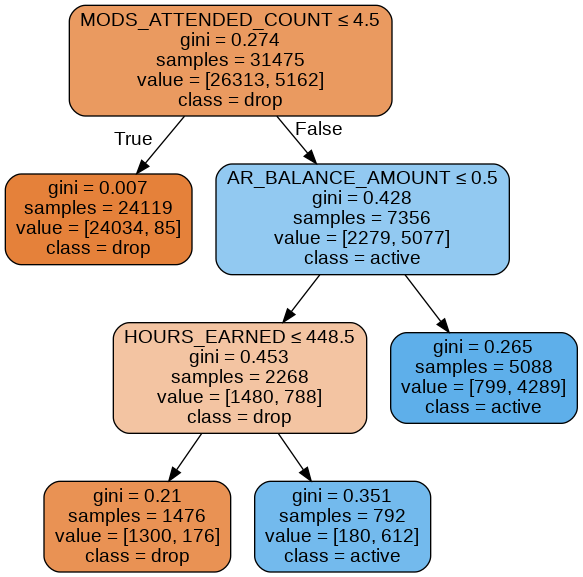

In [ ]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus, six
  
dot_data = StringIO()
export_graphviz(clf_student, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names = X.columns,class_names=['drop', 'active'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('lab3.png')
Image(graph.create_png())

The model has learned that the number of months that a student has attended the college is the most important feature in predicting whether they will drop out or not. Of those who have attended for less than 4.5 months, 99.6% (24054/24147) drop out. Of the students who have attended for more than 4.5 months, those who owe less money and have less credit hours are more likely to drop out than those who have more debt.